# Deep Learning Framework for Multimodal Brain Tumor Segmentation: BraTS 2020

### 1. Introduction & Objectives
This notebook implements an advanced deep learning pipeline for the automated segmentation of brain tumors. Using the **Multimodal Brain Tumor Segmentation Challenge 2020 (BraTS 2020)** dataset, we aim to classify each voxel of an MRI scan into one of four distinct categories:
* **Class 0:** Background (Healthy tissue)
* **Class 1:** Necrotic and Non-Enhancing Tumor (NCR/NET)
* **Class 2:** Peritumoral Edema (ED)
* **Class 3:** Enhancing Tumor (ET)



### 2. Architectural Evolution
The system is built on a flexible backbone, allowing for the evaluation of three progressively advanced **U-Net** architectures:
1.  **Standard U-Net:** The baseline encoder-decoder architecture with skip connections.
2.  **Residual U-Net (Res-UNet):** Integrates **Residual Blocks** to facilitate gradient flow and enable deeper feature extraction.
3.  **Attention Residual U-Net:** Our state-of-the-art implementation that incorporates **Attention Gates (AGs)** to selectively highlight salient tumor features while suppressing irrelevant background noise.




### 3. Key Technical Features
* **Hybrid Loss Function:** To combat extreme class imbalance, the model is optimized using a weighted combination of **Categorical Cross-Entropy (or Focal Loss)** and **Dice Loss**.
* **Multimodal Input:** The pipeline utilizes multiple MRI sequences (T1, T1ce, T2, FLAIR) to provide the network with a rich spatial and structural context.
* **Adaptive Learning:** Implements **Early Stopping** and **Learning Rate Decay** (ReduceLROnPlateau) to ensure stable convergence and prevent overfitting.
* **Experiment Tracking:** Fully integrated with **Weights & Biases (W&B)** for real-time logging of metrics, gradient histograms, and visual segmentation samples.



### 4. Evaluation Strategy
Beyond simple accuracy, we prioritize clinically relevant metrics to validate our results:
* **Dice Similarity Coefficient (DSC):** Measuring spatial overlap.
* **Sensitivity (Recall):** Ensuring the model doesn't miss tumorous tissue.
* **Specificity:** Minimizing false positives in healthy brain regions.
* **Voxel-wise Confusion Matrix:** Detailed error analysis excluding background dominance.



### 5. Hardware & Environment
This notebook is optimized for high-performance GPU environments. It utilizes `torch.inference_mode()` for efficient evaluation and automated artifact logging for model persistence.

# 1. Environment Setup and Dependency Initialization

This section initializes the development environment by importing the necessary libraries for data processing, medical imaging, and deep learning.

* **Medical Imaging:** `nibabel` is used for handling NIfTI (.nii) files common in the BraTS dataset.
* **Deep Learning Framework:** We utilize **PyTorch** for model architecture, optimization, and training.
* **Experiment Tracking:** `wandb` (Weights & Biases) is integrated for real-time logging and performance monitoring.
* **Hardware Acceleration:** The final block checks for **CUDA** (NVIDIA) or **MPS** (Apple Silicon) availability to ensure optimal training speed.

In [2]:
import nibabel as nib
import os
import zipfile
from tqdm import tqdm
import logging
import wandb

import random
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Optimizer, Adam, SGD, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import Tensor
from torchmetrics.classification import ConfusionMatrix

if torch.cuda.is_available():
    print(f"CUDA detected, device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA not detected")

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

CUDA detected, device: NVIDIA GeForce RTX 3060


# 2. Dataset Extraction and File Standardization

This section handles the initial data setup and ensures consistency across the dataset.

* **Extraction Logic:** The script checks if the dataset has already been unzipped to avoid redundant operations and save time.
* **Fixing Metadata Inconsistency:** There is a known naming error in the official BraTS 2020 Training set (Patient 355). 
    * *Issue:* One segmentation file is named `W39_1998.09.19_Segm.nii` instead of the expected `BraTS20_Training_355_seg.nii`.
    * *Fix:* The script renames this file to follow the standard naming convention, ensuring the `DataLoader` can find it automatically.

In [3]:
# Path to the directory where files will be extracted
extracted_dir = "brats20-dataset-training-validation"

path_to_zip_file = "brats20-dataset-training-validation.zip"

# Check if the directory exists and is not empty
if not os.path.exists(extracted_dir) or not os.listdir(extracted_dir):
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir)
        print(f"Extracted to {extracted_dir}")
else:
    print(f"{extracted_dir} already exists and is not empty. Skipping extraction.")

# Absolute path of the incorrectly named file
old_name = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii"

# Renaming the file
try:
    os.rename(old_name, new_name)
    print("The file has been successfully renamed")
except FileNotFoundError:
    print("Maybe you have already renamed the file or the file is not misspelled on the dataset anymore")

brats20-dataset-training-validation already exists and is not empty. Skipping extraction.
Maybe you have already renamed the file or the file is not misspelled on the dataset anymore


# 3. Exploratory Data Analysis: Segmentation Labels

In semantic segmentation, each voxel is assigned a label representing a specific tissue type. The BraTS 2020 dataset defines four distinct tumor regions, though the raw data uses non-sequential integers.

### Class Definitions:
* **Label 0:** Healthy tissue or Background (Not Tumor).
* **Label 1:** Necrotic and Non-Enhancing Tumor core (NCR/NET).
* **Label 2:** Peritumoral Edema (ED).
* **Label 4:** Enhancing Tumor (ET).

### Label Mapping Note:
As observed, the dataset skips value **3**. To optimize the model's performance and use a standard 4-class Softmax output, we will map Label 4 to Index 3. 

The following visualizations isolate these classes to understand the spatial distribution and the high class imbalance, where the background (Class 0) represents the vast majority of the data.

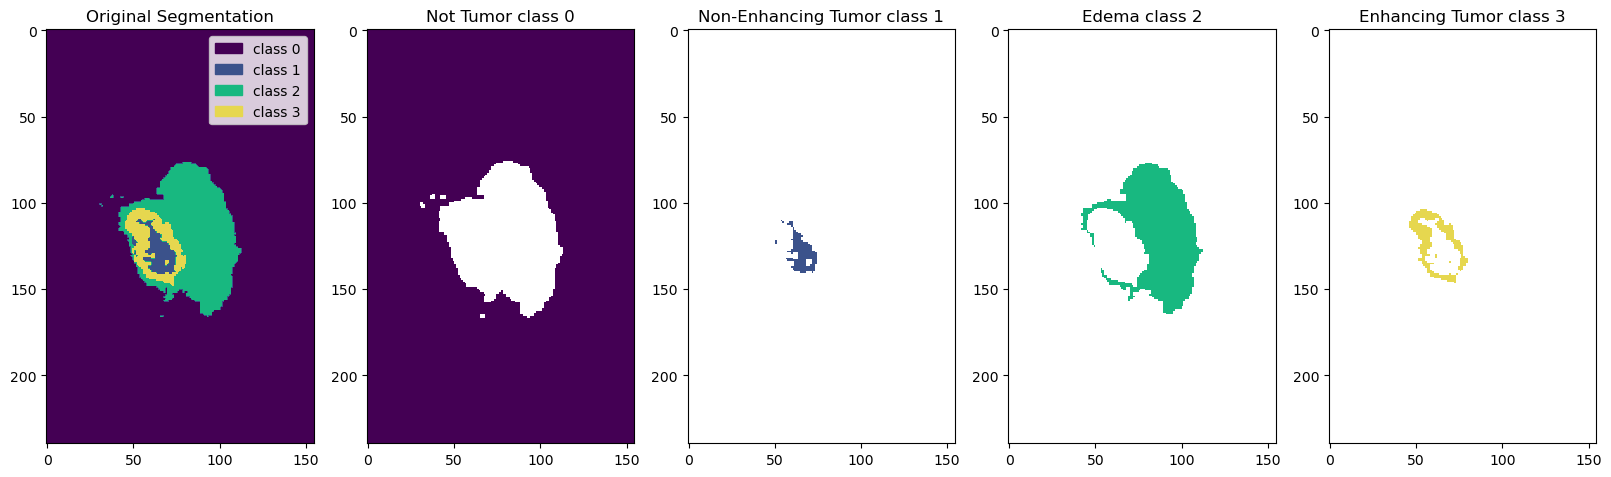

[8716021   15443  168794   27742]


In [4]:
# Plot a segmantation
some_seg_img = nib.load("brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii").get_fdata()
cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# Deletion of class 0
seg_0 = some_seg_img.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = some_seg_img.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = some_seg_img.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_3 = some_seg_img.copy()
seg_3[seg_3 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 3']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, axs3 = plt.subplots(1, 5, figsize=(20, 15))

axs3[0].imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
axs3[0].set_title('Original Segmentation')
axs3[0].legend(handles=legend, loc='upper right')

axs3[1].imshow(seg_0[100,:,:], cmap=cmap, norm=norm)
axs3[1].set_title('Not Tumor class 0')

axs3[2].imshow(seg_1[100,:,:], cmap=cmap, norm=norm)
axs3[2].set_title('Non-Enhancing Tumor class 1')

axs3[3].imshow(seg_2[100,:,:], cmap=cmap, norm=norm)
axs3[3].set_title('Edema class 2')

axs3[4].imshow(seg_3[100,:,:], cmap=cmap, norm=norm)
axs3[4].set_title('Enhancing Tumor class 3')

plt.show()

values, counts = np.unique(some_seg_img, return_counts=True)
print(counts)

# 4. Data Filtering and Subset Partitioning

This phase focuses on selecting the appropriate patient cohorts and establishing a robust evaluation framework through data splitting.

### Clinical Filtering: HGG Samples
Using the `name_mapping.csv` metadata, we specifically filter for **High-Grade Glioma (HGG)** cases. HGGs are more aggressive and often show more distinct imaging features than Low-Grade Gliomas (LGG), making them a primary focus for many segmentation tasks.

### Resource Optimization
Due to the high memory demands of 3D MRI volumes, the dataset is reduced to **one-third of its original size**. This ensures the training process remains stable within the available hardware constraints (RAM/VRAM).

### The Triple-Split Strategy
To prevent "data leakage" and ensure the model generalizes well to unseen patients, we divide the data into three sets:
1.  **Training Set (68%):** Used for backpropagation and weight updates.
2.  **Validation Set (20%):** Used for hyperparameter tuning and monitoring over-fitting during training.
3.  **Test Set (12%):** A completely "unseen" set held back for the final performance report.

In [5]:
# Specify path of our BraTS2020 directory
data_path = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Retrieve all samples from path with listdir(). This method lists of all files + directories in the specified directory.
samples = os.listdir(data_path)

name_df = pd.read_csv(data_path + "/name_mapping.csv")

samples = (name_df[name_df['Grade'] == "HGG"]['BraTS_2020_subject_ID']).to_list()

# Reduce dataset size by half to manage memory constraints
samples = samples[:len(samples) // 3]

print("First of samples:", samples[0])
print("Number of samples:", len(samples))

First of samples: BraTS20_Training_001
Number of samples: 97


In [6]:
# Split the dataset into train and validation sets
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)

# Split the train set into the real train set and in a test set
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 65
Validation length: 20
Test length: 12


# 5. Data Pipeline: Custom PyTorch Dataset Implementation

To feed the 3D MRI data into our 2D U-Net, we implement a custom `Brats20DatasetAllAtOnce` class inherited from `torch.utils.data.Dataset`. 

### Key Features of the Pipeline:
* **Memory Management (Pre-allocation):** The dataset pre-allocates memory for all slices at initialization. This "All-at-once" strategy significantly speeds up the training loop by eliminating disk I/O bottlenecks during epochs.
* **Volume Slicing:** To focus on the most relevant anatomical regions, we extract 75 slices per patient, starting from index 60. This removes the "empty" top and bottom slices of the brain scan.
* **Spatial Standardization:** Every slice is resized from its native resolution to **128x128** pixels using `OpenCV`.
* **Label Processing:** 
    * **Remapping:** Label 4 is converted to 3 to create a continuous class range [0, 1, 2, 3].
    * **One-Hot Encoding:** Masks are transformed into a 4-channel representation, where each channel corresponds to a specific tissue class.
* **Handling Class Imbalance (Non-tumor Dropout):** Many slices contain no tumor. We implemented a `dropout_non_tumor` mechanism to randomly skip empty slices, forcing the model to focus more on rare tumorous regions.

In [7]:
# Define image size
IMG_SIZE = 128

# Define selected slices range
VOLUME_START_AT = 60
VOLUME_SLICES = 75

class Brats20DatasetAllAtOnce(Dataset):
    def __init__(self, data_path, list_ids, dim=(IMG_SIZE, IMG_SIZE), num_channels=2, num_classes=4, dropout_non_tumor=0.0):
        self.dim = dim
        self.list_ids = list_ids
        self.n_channels = num_channels
        self.num_classes = num_classes
        self.dropout_non_tumor = dropout_non_tumor
        self.data_path = data_path

        # Estimate total samples to allocate memory
        total_samples = len(list_ids) * VOLUME_SLICES
        self.data = np.zeros((total_samples, self.n_channels, *self.dim), dtype=np.float32)
        self.labels = np.zeros((total_samples, self.num_classes, *self.dim), dtype=np.float32)

        index = 0
        for patient_id in self.list_ids:
            sample_path = os.path.join(self.data_path, patient_id, patient_id)
            t1_path = sample_path + '_t1.nii'
            t2_path = sample_path + '_t2.nii'
            t1ce_path = sample_path + '_t1ce.nii'
            flair_path = sample_path + '_flair.nii'
            seg_path = sample_path + '_seg.nii'

            t1 = nib.load(t1_path).get_fdata()
            t2 = nib.load(t2_path).get_fdata()
            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()

            x_nibs = [t1ce, flair, t1, t2]

            for j in range(VOLUME_START_AT, VOLUME_START_AT + VOLUME_SLICES):
                # Resize and prepare the input data
                sample_data = np.stack([cv2.resize(x_nibs[t][:, :, j], self.dim) for t in range(self.n_channels)])

                y_num = seg[:, :, j].astype(int)
                y_num[y_num == 4] = 3
                mask = np.eye(self.num_classes)[y_num]
                sample_labels = np.stack([cv2.resize(mask[:, :, i], self.dim) for i in range(self.num_classes)])

                # Check for non-tumor sample and apply dropout
                if np.all(sample_labels[0] == 1) and np.all(sample_labels[1:] == 0):
                    if np.random.rand() < self.dropout_non_tumor:
                        continue  # Skip this non-tumor sample with the given probability

                # Assign sample data directly to pre-allocated arrays
                self.data[index] = sample_data
                self.labels[index] = sample_labels
                index += 1

        # Trim the arrays to the actual number of samples loaded
        self.data = self.data[:index]
        self.labels = self.labels[:index]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.from_numpy(self.data[index]), torch.from_numpy(self.labels[index])
    
    def count_non_tumor_samples(self):
        non_tumor_count = 0
        for y in self.labels:
            if np.all(y[0] == 1) and np.all(y[1:] == 0):
                non_tumor_count += 1
        return non_tumor_count

# 6. Dataset Instantiation and Batching Strategy

In this stage, we finalize the data pipeline by configuring the input dimensions and wrapping our datasets into PyTorch `DataLoaders`.

### Configuration Parameters:
* **Multimodal Input (`num_channels = 4`):** Unlike the initial baseline, we are now utilizing all four MRI modalities (T1, T1ce, T2, and FLAIR). This provides the U-Net with a richer feature set, as different tumor components are more visible in specific modalities.
* **Class Count (`num_classes = 4`):** Represents the background and the three distinct tumor regions.
* **Batch Size (`batch_size = 16`):** Balanced to maximize GPU memory utilization while maintaining stable gradient updates.

### The Role of DataLoaders:
The `DataLoader` is responsible for feeding the model in organized chunks (batches). 
* **Training Set:** `shuffle=True` is applied to ensure the model doesn't learn the order of patients, improving generalization.
* **Validation & Test Sets:** `shuffle=False` is used to maintain a consistent evaluation order for performance metrics.

In [8]:
# num_channels = 2
num_channels = 4 
num_classes = 4
batch_size = 16


train_dataset = Brats20DatasetAllAtOnce(data_path, samples_train, num_channels=num_channels, num_classes=num_classes)
valid_dataset = Brats20DatasetAllAtOnce(data_path, samples_val, num_channels=num_channels, num_classes=num_classes)
test_dataset = Brats20DatasetAllAtOnce(data_path, samples_test, num_channels=num_channels, num_classes=num_classes)

# Use DataLoader to batch and shuffle data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 7. Visual Sanity Check: Modalities and Masks

Before proceeding to the training phase, it is crucial to verify that our data pipeline is correctly processing the MRI volumes. This section selects a random slice from the training set and visualizes both the input and output tensors.

### Input Channels (MRI Modalities):
We plot all **4 input channels** to ensure that each modality (T1, T1ce, T2, and FLAIR) is correctly loaded, resized, and normalized. Each channel provides unique information about the brain's anatomy and the tumor's characteristics.

### Output Channels (Segmentation Masks):
We visualize the **4-class one-hot encoded masks**. This allows us to verify:
1.  **Class 0:** The overall brain structure (background).
2.  **Class 1-3:** The specific tumor regions (Necrosis, Edema, Enhancing Tumor).

By inspecting these images, we can confirm that the ground truth labels are spatially aligned with the anatomical features in the MRI channels.

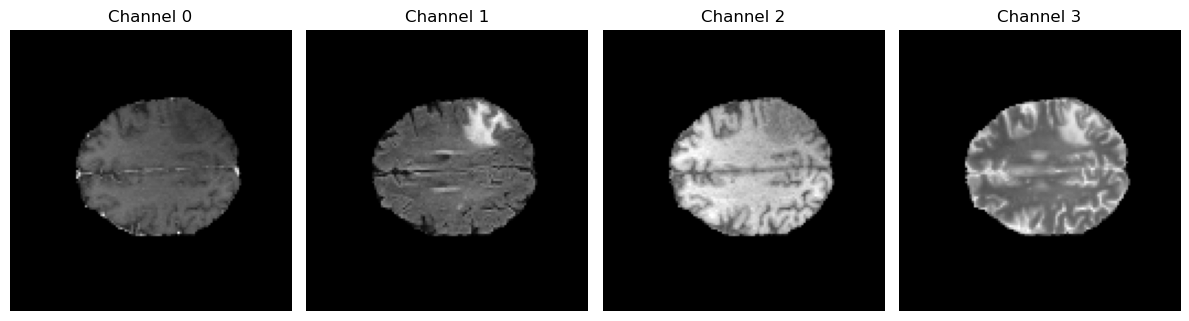

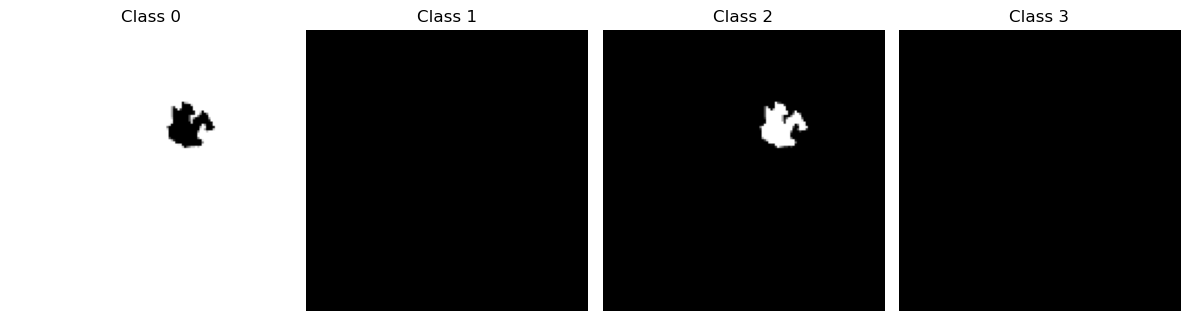

In [9]:
plot_x, plot_y = train_dataset[random.randint(0, len(train_dataset))]

# Plot input channels
channel_numpy = plot_x.numpy()

num_channels = plot_x.shape[0]

fig, axes = plt.subplots(1, num_channels, figsize=(12, 5))

for i in range(num_channels):
    axes[i].imshow(channel_numpy[i], cmap='gray')
    axes[i].set_title(f'Channel {i}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Plot output classes
mask_numpy = plot_y.numpy()

num_classes = plot_y.shape[0]

# Create a figure and axes for subplots
fig, axes = plt.subplots(1, num_classes, figsize=(12, 5))

# Plot each class channel
for i in range(num_classes):
    axes[i].imshow(mask_numpy[i], cmap='gray')
    axes[i].set_title(f'Class {i}')
    axes[i].axis('off')  # Hide axis ticks

plt.tight_layout()
plt.show()

# 8. UNet1: Dynamic U-Net Implementation

This section defines the **UNet1** class, a flexible PyTorch implementation of the U-Net architecture. Unlike static models, this version allows for adjustable depth and filter counts to optimize for specific hardware or accuracy requirements.



### Structural Components:
* **Contracting Path (Encoder):** A series of dual 3x3 convolutions followed by ReLU activations and 2x2 Max Pooling. This path captures the "what" (features) but loses the "where" (precise location).
* **Bottleneck:** The transition layer at the lowest resolution, featuring a **Dropout layer** to enhance the model's generalization capabilities.
* **Expansive Path (Decoder):** Utilizes `ConvTranspose2d` for upsampling. It progressively restores spatial resolution.
* **Skip Connections:** A defining feature of U-Net. We concatenate high-resolution feature maps from the encoder directly into the decoder. This preserves spatial information, allowing the model to recover fine details of tumor boundaries.
* **Final Layer:** A 1x1 convolution maps the final feature vector to the 4 target classes.

In [10]:
class UNet1(nn.Module):
    def __init__(self, in_channels=2, out_channels=4, depth=4, filters=80, dropout=0.2):
        super(UNet1, self).__init__()

        # Calculate minimum possible filters based on depth
        min_filters = filters // (2 ** depth)
        assert min_filters > 0, "Depth too large: filters would become zero or negative."
        
        self.depth = depth
        self.filters = filters
        self.dropout = nn.Dropout(dropout)

        # Contracting Path
        self.down_convs = nn.ModuleList()
        self.pools = nn.ModuleList()
        
        for i in range(depth):
            in_ch = in_channels if i == 0 else filters // (2**(i-1))
            out_ch = filters // (2**i)
            self.down_convs.append(self.conv_block(in_ch, out_ch))
            self.pools.append(nn.MaxPool2d(2))
        
        # Bottom Layer (last convolution before upsampling path)
        self.bottom_conv = self.conv_block(filters // (2**(depth-1)), filters // (2**depth))
        
        # Expansive Path
        self.up_convs = nn.ModuleList()
        self.ups = nn.ModuleList()
        
        for i in range(depth - 1, -1, -1):
            in_ch = filters // (2**(i+1))
            out_ch = filters // (2**i)
            self.ups.append(nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2))
            self.up_convs.append(self.conv_block(out_ch * 2, out_ch))
        
        # Final Convolution Layer
        self.final_conv = nn.Conv2d(filters, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Contracting Path
        encodings = []
        for i in range(self.depth):
            x = self.down_convs[i](x)
            encodings.append(x)
            x = self.pools[i](x)
        
        # Bottom Layer
        x = self.bottom_conv(x)
        x = self.dropout(x)

        # Expansive Path
        for i in range(self.depth - 1, -1, -1):
            x = self.ups[self.depth - 1 - i](x)
            x = torch.cat([encodings[i], x], dim=1)
            x = self.up_convs[self.depth - 1 - i](x)

        # Final Convolution
        x = self.final_conv(x)
        return x

# 9. UNet2: Integrating Residual Connections

This implementation evolves the standard U-Net by incorporating **Residual Blocks**, which help overcome the vanishing gradient problem in deeper architectures.

### Key Enhancements:
* **Residual Learning:** Each block computes a residual function $F(x)$ and adds the original input $x$ back to it ($y = F(x) + x$). This allows the network to learn identity mappings more easily.
* **Batch Normalization:** Included after each convolution to accelerate training and provide a slight regularization effect by reducing internal covariate shift.
* **Kaiming Initialization:** The `_init_weights` method uses He initialization (Kaiming Normal), which is mathematically optimized for layers followed by ReLU activation functions.
* **Downsampling Shortcut:** If the number of input and output channels doesn't match, a 1x1 convolution is used in the shortcut path to align dimensions for the element-wise addition.

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, set_init_weights: bool=False) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=(3, 3), 
            padding='same', 
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=out_channels, 
            out_channels=out_channels, 
            kernel_size=(3, 3), 
            padding='same', 
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, 
                    out_channels, 
                    kernel_size=(3, 3), 
                    padding='same', 
                    bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )
            
        # Apply Kaiming initialization to the conv layers
        if set_init_weights:
            self._init_weights()

    def _init_weights(self):
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, mode='fan_in', nonlinearity='relu')
        if self.downsample:
            nn.init.kaiming_normal_(self.downsample[0].weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = self.downsample(x) if self.downsample else x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x + identity)

        return x

class UNet2(nn.Module):
    def __init__(self, in_channels=2, out_channels=4, depth=4, filters=80, dropout=0.2):
        super(UNet2, self).__init__()

        # Calculate minimum possible filters based on depth
        min_filters = filters // (2 ** depth)
        assert min_filters > 0, "Depth too large: filters would become zero or negative."
        
        self.depth = depth
        self.filters = filters
        self.dropout = nn.Dropout(dropout)

        # Contracting Path
        self.down_convs = nn.ModuleList()
        self.pools = nn.ModuleList()
        
        for i in range(depth):
            in_ch = in_channels if i == 0 else filters // (2**(depth-i+1))
            out_ch = filters // (2**(depth-i))
            self.down_convs.append(self.res_conv_block(in_ch, out_ch))
            self.pools.append(nn.MaxPool2d(2))
        
        # Bottom Layer (last convolution before upsampling path)
        self.bottom_conv = self.res_conv_block(filters // 2, filters )
        
        # Expansive Path
        self.up_convs = nn.ModuleList()
        self.ups = nn.ModuleList()
        
        for i in range(depth - 1, -1, -1):
            in_ch = filters // (2**(depth-i-1))
            out_ch = filters // (2**(depth-i))
            self.ups.append(nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2))
            self.up_convs.append(self.res_conv_block(out_ch * 2, out_ch))
        
        # Final Convolution Layer
        self.final_conv = nn.Conv2d(filters // 2 ** depth, out_channels, kernel_size=1)

    def res_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(out_channels, out_channels)
        )

    def forward(self, x):
        # Contracting Path
        encodings = []
        for i in range(self.depth):
            x = self.down_convs[i](x)
            encodings.append(x)
            x = self.pools[i](x)
        
        # Bottom Layer
        x = self.bottom_conv(x)
        x = self.dropout(x)

        # Expansive Path
        for i in range(self.depth - 1, -1, -1):
            x = self.ups[self.depth - 1 - i](x)
            x = torch.cat([encodings[i], x], dim=1)
            x = self.up_convs[self.depth - 1 - i](x)

        # Final Convolution
        x = self.final_conv(x)
        return x

# 10. UNet3: Residual Blocks with Attention Gating

This model represents our most complex architecture, utilizing spatial attention to refine the skip connection process.

**Architecture Workflow:**
1.  **Gating Signal ($g$):** Derived from the lower, more abstract level of the expansive path.
2.  **Input Signal ($x$):** The high-resolution features from the contracting path.
3.  **Coefficient ($\psi$):** A sigmoid-activated attention coefficient that identifies where the model should "pay attention."
4.  **Res-Conv Blocks:** Like `UNet2`, this model uses double residual blocks for deeper feature extraction.

> **Feature Highlight:** The `AttentionGate` uses $1 \times 1$ convolutions to project features into an intermediate space ($F_{int}$) before calculating the attention map, keeping the computational overhead minimal while maximizing performance.

In [12]:
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int, set_init_weights: bool=False):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)

        # Initialize weights for the attention gates
        if set_init_weights:
            self._init_weights()

    def _init_weights(self):
        # Kaiming initialization for the conv layers in AttentionGate
        nn.init.kaiming_normal_(self.W_g[0].weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.W_x[0].weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.psi[0].weight, mode='fan_in', nonlinearity='relu')
        
        if self.W_g[1].weight is not None:
            nn.init.ones_(self.W_g[1].weight)
            nn.init.zeros_(self.W_g[1].bias)
        
        if self.W_x[1].weight is not None:
            nn.init.ones_(self.W_x[1].weight)
            nn.init.zeros_(self.W_x[1].bias)
        
        if self.psi[1].weight is not None:
            nn.init.ones_(self.psi[1].weight)
            nn.init.zeros_(self.psi[1].bias)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class UNet3(nn.Module):
    def __init__(self, in_channels=2, out_channels=4, depth=4, filters=80, dropout=0.2, set_init_weights: bool=False):
        super(UNet3, self).__init__()

        self.set_init_weights = set_init_weights

        min_filters = filters // (2 ** depth)
        assert min_filters > 0, "Depth too large: filters would become zero or negative."

        self.depth = depth
        self.filters = filters
        self.dropout = nn.Dropout(dropout)

        # Contracting Path
        self.down_convs = nn.ModuleList()
        self.pools = nn.ModuleList()
        
        for i in range(depth):
            in_ch = in_channels if i == 0 else filters // (2**(depth-i+1))
            out_ch = filters // (2**(depth-i))
            self.down_convs.append(self.res_conv_block(in_ch, out_ch))
            self.pools.append(nn.MaxPool2d(2))
        
        # Bottom Layer
        self.bottom_conv = self.res_conv_block(filters // 2, filters)
        
        # Expansive Path
        self.up_convs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.attention_gates = nn.ModuleList()
        
        for i in range(depth - 1, -1, -1):
            in_ch = filters // (2**(depth-i-1))
            out_ch = filters // (2**(depth-i))
            self.ups.append(nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2))
            self.up_convs.append(self.res_conv_block(out_ch * 2, out_ch))
            
            # Initialize AttentionGate for each skip connection
            F_g = out_ch  # Decoder feature map size
            F_l = out_ch  # Encoder feature map size
            F_int = F_l // 2
            self.attention_gates.append(AttentionGate(F_g, F_l, F_int, set_init_weights=self.set_init_weights))
        
        # Final Convolution Layer
        self.final_conv = nn.Conv2d(filters // 2 ** depth, out_channels, kernel_size=1)

        # Initialize weights for the final layer
        if self.set_init_weights:
            self._init_weights()

    def res_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, set_init_weights=self.set_init_weights),
            ResidualBlock(out_channels, out_channels, set_init_weights=self.set_init_weights)
        )

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        encodings = []
        for i in range(self.depth):
            x = self.down_convs[i](x)
            encodings.append(x)
            x = self.pools[i](x)
        
        x = self.bottom_conv(x)
        x = self.dropout(x)

        for i in range(self.depth - 1, -1, -1):
            x = self.ups[self.depth - 1 - i](x)
            attention = self.attention_gates[self.depth - 1 - i](x, encodings[i])
            x = torch.cat([attention, x], dim=1)
            x = self.up_convs[self.depth - 1 - i](x)

        x = self.final_conv(x)
        return x

# 11. Loss Function and Metrics: Dice Coefficient

For brain tumor segmentation, standard pixel-wise Cross-Entropy often fails due to the extreme class imbalance. Instead, we implement the **Sørensen–Dice Coefficient**.

### Mathematical Formulation
The Dice Score evaluates the similarity between the predicted mask ($X$) and the ground truth ($Y$):

$$Dice(X, Y) = \frac{2 |X \cap Y|}{|X| + |Y|}$$

### Why Dice?
1. **Class Imbalance:** It is robust against large background areas.
2. **Overlap Focus:** It directly optimizes for the intersection of the segmented regions.
3. **Differentiable:** By using the soft Dice formula, we can use it as a loss function ($1 - Dice$) for backpropagation.

### Implementation Features:
* **Background Exclusion:** The `skip_bg` parameter allows the metric to focus only on the 3 tumor-related classes, ignoring the dominant healthy tissue.
* **Epsilon Smoothing:** A stability term ($1e-6$) is added to ensure numerical stability during training.
* **Batch Reduction:** The loss is calculated per sample and then averaged across the batch to ensure consistent gradient updates.

In [13]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6, skip_bg: bool = True):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    # Skip the background (first class) if specified
    if skip_bg:
        input = input[:, 1:] if input.dim() == 4 else input[1:]
        target = target[:, 1:] if target.dim() == 4 else target[1:]

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()

def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6, skip_bg: bool = True):
    # Average of Dice coefficient for all classes, optionally skipping background
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon, skip_bg)

def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False, skip_bg: bool = True):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True, skip_bg=skip_bg)

# 12. Safeguarding the Model: Early Stopping

Early stopping is a form of regularization used to avoid overfitting. It monitors the model's performance on a held-out validation set and stops the training once the performance stops improving.

* **Monitoring:** It watches the `val_loss` at the end of every epoch.
* **Patience:** We allow a 3-epoch "grace period" to account for minor fluctuations in the loss curve.
* **Resource Efficiency:** By stopping early, we save GPU hours and prevent the model from drifting into a state of high variance.

In [14]:
# EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

# 13. Training Step Implementation

The `train()` function manages the backpropagation process and model parameter updates.

**Mathematical Workflow:**
1.  **Prediction:** Forward pass through the model to get raw logits.
2.  **Hybrid Loss Calculation:** $$Total\_Loss = (1 - \alpha) \cdot L_{CE} + \alpha \cdot L_{Dice}$$
    *where $\alpha$ is `percent_dice_loss`.*
3.  **Backpropagation:** `optimizer.zero_grad()`, `loss.backward()`, and `optimizer.step()`.

**Visualization Logic:**
To monitor the training quality, every 10% of the epoch, the code converts the segmentation masks into RGB format using a custom colormap and logs them to the W&B dashboard. This allows us to see how the model's "understanding" of the tumor evolves batch by batch.

In [15]:
def train(dataloader: DataLoader, model: nn.Module, loss_fn, optimizer: torch.optim.Optimizer, percent_dice_loss = 0.5, skip_bg=True):
    global global_step, epoch, epochs

    assert 0 <= percent_dice_loss <= 1, "Ther percent of the dice score should be between 0 and 1"

    size = len(dataloader.dataset)
    total_loss = 0
    size_batches = len(dataloader) // 10
    model.train()
    with tqdm(total=size, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            pred = model(x)
            ce_or_focal_loss = loss_fn(pred, y.argmax(dim=1))

            ds_loss = dice_loss(
                F.softmax(pred, dim=1).float(),
                y.float(),
                multiclass=True,
                skip_bg=skip_bg
            ) 
            # loss = ce_loss * (1 - percent_dice_loss) + ds_loss * percent_dice_loss
            loss = ce_or_focal_loss * (1 - percent_dice_loss) + ds_loss * percent_dice_loss
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.update(x.shape[0])
            pbar.set_postfix(**{'loss': loss.item()})

            if isinstance(loss_fn, nn.CrossEntropyLoss):
                wandb.log({'ce_loss': ce_or_focal_loss, 'dice_loss': ds_loss, 'loss': loss}, step=global_step, commit=False)
            else:
                wandb.log({'focal_loss': ce_or_focal_loss, 'dice_loss': ds_loss, 'loss': loss}, step=global_step, commit=False)

            if batch % size_batches == 0:
                histograms = {}
                for tag, value in model.named_parameters():
                    tag = tag.replace('/', '.')
                    if not (torch.isinf(value) | torch.isnan(value)).any():
                        histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                    if value.grad is not None and not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                        histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                def mask_to_rgb(mask, cmap, norm):
                    """
                    mask: (H, W) tensor or numpy array with class indices
                    returns: (H, W, 3) uint8 RGB image
                    """
                    if torch.is_tensor(mask):
                        mask = mask.cpu().numpy()

                    rgba = cmap(norm(mask))          # (H, W, 4)
                    rgb = (rgba[..., :3] * 255).astype(np.uint8)
                    return rgb

                true_mask = y.argmax(dim=1)[0]
                pred_mask = pred.argmax(dim=1)[0]

                true_rgb = mask_to_rgb(true_mask, cmap, norm)
                pred_rgb = mask_to_rgb(pred_mask, cmap, norm)

                wandb.log({
                    'learning rate': optimizer.param_groups[0]['lr'],
                    'epoch': epoch,
                    'train sample': [
                        wandb.Image(x[0].cpu(), caption='original slice'), 
                        wandb.Image(true_rgb, caption='true mask'),
                        wandb.Image(pred_rgb, caption='predicted mask')
                    ],
                    **histograms
                }, step=global_step)
            global_step += 1

# 14. Model Validation and Performance Metrics

The `validate()` function provides an unbiased evaluation of the model's performance during training. It measures how well the U-Net generalizes to the validation patient cohort.

### Technical Safeguards:
* **`@torch.inference_mode()`:** This modern PyTorch decorator is used for maximum efficiency. It disables gradient tracking and view tracking, significantly reducing memory usage and speeding up the forward pass.
* **`model.eval()`:** Sets the model to evaluation mode. This is critical for layers like **Batch Normalization** and **Dropout**, ensuring they use population statistics and are deactivated during testing.
* **Hard Dice Calculation:** While the loss uses a "soft" Dice (probabilities), the final `dice_score` is calculated using `argmax` to create a binary mask. This represents the actual performance we would see in a clinical setting.



### Outputs:
* **Validation Loss:** A combination of Cross-Entropy and Dice Loss, used to monitor convergence.
* **Dice Score:** The primary metric for medical segmentation accuracy (range 0 to 1).

In [16]:
@torch.inference_mode()
def validate(dataloader: DataLoader, model: nn.Module, loss_fn, percent_dice_loss = 0.5, skip_bg=True):
    assert 0 <= percent_dice_loss <= 1, "Ther percent of the dice score should be between 0 and 1"

    model.eval()

    num_batches = len(dataloader)
    total_loss = 0
    dice_score = 0
    
    for x, y in tqdm(dataloader, total=num_batches, desc='Validation round', unit='batch', leave=False):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        total_loss += loss_fn(pred, y.argmax(dim=1)).item() * (1 - percent_dice_loss)

        total_loss += dice_loss(
            F.softmax(pred, dim=1).float(),
            y.float(),
            multiclass=True,
            skip_bg=skip_bg
        ) * percent_dice_loss

        mask_pred = F.one_hot(pred.argmax(dim=1), num_classes).permute(0, 3, 1, 2).float()
        mask_true = y.float()
        dice_score += multiclass_dice_coeff(mask_pred, mask_true, reduce_batch_first=False, skip_bg=False)
            
    total_loss /= num_batches
    dice_score /= num_batches
    
    model.train()

    return total_loss, dice_score

# 15. Orchestrating the Training Pipeline

This final block integrates the model, data, and optimization strategy into a cohesive experiment.

### Configuration & Hyperparameters
We use a centralized `config` dictionary to track all critical parameters. This is pushed to **Weights & Biases**, ensuring that every experiment is documented and reproducible. Key parameters include:
* **Hybrid Loss:** `percent_dice_loss=0.5` balances voxel-wise classification with regional overlap.
* **Optimization:** `AdamW` with a weight decay of `8e-5` for robust regularization.

### Advanced Learning Control
* **Dynamic LR Scaling:** The `ReduceLROnPlateau` scheduler actively monitors the validation loss, cutting the learning rate when progress stalls. This "fine-tunes" the model in the later stages of training.
* **Early Stopping:** A 10-epoch patience window ensures we stop exactly when the model reaches its peak generalization capability.

### Artifacts and Serialization
Once training is complete (or stopped), the model's state is serialized and uploaded as a **W&B Artifact**. This creates a permanent link between the training logs, the code version, and the resulting model weights, facilitating seamless deployment or further testing.

In [52]:
epochs = 30

#Configuration
config = dict(
    epochs=epochs,
    init_lr=1e-3,
    lr_reducer_factor=0.5,
    lr_reducer_patience=2,
    min_lr=1e-6,
    es_patience=10,
    es_min_delta=1e-4,
    weight_decay=0.00008,
    percent_dice_loss=0.5,
    skip_bg=True,
    num_channels=num_channels,
    num_classes=num_classes,
    model_name='unet3',
    model_depth=3,
    model_filters=256, 
    model_dropout=0.3,
    dropout_non_tumor=0
)


# Initialize wandb
run = wandb.init(project='autonom-brats20', config=config)
config = run.config

model = None
if config.model_name == 'unet1':
    # Model setup
    model = UNet1(
        in_channels=config.num_channels, out_channels=config.num_classes, 
        depth=config.model_depth, filters=config.model_filters, dropout=config.model_dropout
    ).to(device)
elif config.model_name == 'unet2':
    model = UNet2(
        in_channels=config.num_channels, out_channels=config.num_classes, 
        depth=config.model_depth, filters=config.model_filters, dropout=config.model_dropout
    ).to(device) 
elif config.model_name == 'unet3':
    model = UNet3(
        in_channels=config.num_channels, out_channels=config.num_classes, 
        depth=config.model_depth, filters=config.model_filters, dropout=config.model_dropout
    ).to(device) 
assert not (model == None), 'Model not found'

# Loss, optimizer, and scheduler

loss_fn = nn.CrossEntropyLoss()

optimizer = AdamW(model.parameters(), lr=config.init_lr, weight_decay=config.weight_decay)


scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=config.lr_reducer_factor,
    patience=config.lr_reducer_patience, 
    min_lr=config.min_lr,
)

# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=config.es_patience, min_delta=config.es_min_delta) 

# Logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

global_step = 0

# Training loop
for epoch in range(1, config.epochs + 1):

    train(train_loader, model, loss_fn, optimizer, percent_dice_loss=config.percent_dice_loss, skip_bg=config.skip_bg)
    val_loss, dice_score = validate(val_loader, model, loss_fn, percent_dice_loss=config.percent_dice_loss, skip_bg=config.skip_bg)
    scheduler.step(val_loss)
    logging.info(f'Validation dice score: {dice_score} and loss: {val_loss}')

    # Log metrics to wandb
    wandb.log({
        'val_loss': val_loss,
        'val_dice_score': dice_score
    }, step=global_step)

    # EarlyStopping check
    if early_stopping(val_loss):
        logging.info(f"Early stopping triggered at epoch {epoch}")
        break

# Log the number of parameters of the model
num_of_parameters = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_of_parameters}")
wandb.run.summary["Model Parameters"] = num_of_parameters

# Define the model directory and path
model_dir = "models"
model_path = os.path.join(model_dir, "model.pth")

# Create the directory if it does not exist
os.makedirs(model_dir, exist_ok=True)
torch.save(model.state_dict(), model_path)

# Log model to wandb as an artifact
artifact = wandb.Artifact(name="UNet-model", type="model")
artifact.add_file(model_path)
run.log_artifact(artifact)

Epoch 1/30: 100%|██████████| 4875/4875 [00:42<00:00, 114.85img/s, loss=0.0205] 
INFO:root:Validation dice score: 0.8147794604301453 and loss: 0.011873074807226658
Epoch 2/30: 100%|██████████| 4875/4875 [00:42<00:00, 115.50img/s, loss=0.011]  
INFO:root:Validation dice score: 0.8178922533988953 and loss: 0.009317421354353428
Epoch 3/30: 100%|██████████| 4875/4875 [00:42<00:00, 114.93img/s, loss=0.00443]
INFO:root:Validation dice score: 0.8213627934455872 and loss: 0.009038327261805534
Epoch 4/30: 100%|██████████| 4875/4875 [00:42<00:00, 114.96img/s, loss=0.00905]
INFO:root:Validation dice score: 0.8453549146652222 and loss: 0.008627970702946186
Epoch 5/30: 100%|██████████| 4875/4875 [00:42<00:00, 115.11img/s, loss=0.00723]
INFO:root:Validation dice score: 0.8555392622947693 and loss: 0.007979773916304111
Epoch 6/30: 100%|██████████| 4875/4875 [00:41<00:00, 116.28img/s, loss=0.00704]
INFO:root:Validation dice score: 0.8530403971672058 and loss: 0.008509025909006596
Epoch 7/30: 100%|█████

Number of parameters: 4683005


<Artifact UNet-model>

# 16. Qualitative Evaluation: Visualizing Segmentation Results

After training, it is essential to perform a qualitative check to see how the model generalizes to the test dataset. This section visualizes a random sample from the test cohort, comparing the model's predictions against the professional radiological annotations.

### Visualization Matrix:
* **Top Row (Inputs):** Displays the raw MRI modalities provided to the network.
* **Middle Row (Ground Truth):** Shows the "True" segmentation masks annotated by experts.
* **Bottom Row (Predictions):** Shows the "Predicted" masks generated by the trained U-Net.



### Interpretability Features:
1. **Isolated Class Maps:** We visualize each of the 4 classes (Background, Necrotic Core, Peritumoral Edema, Enhancing Tumor) in separate columns. This allows us to identify specific strengths or weaknesses in the model's tissue classification.
2. **Color Coding:** A custom `ListedColormap` is used to ensure high contrast between different tumor regions.
3. **W&B Integration:** The final comparative figure is automatically uploaded to the **Weights & Biases** dashboard, keeping a visual history of our model's performance evolution.

> **Key Observation:** Pay attention to how the model handles thin tumor boundaries. In medical segmentation, the spatial overlap (Dice) is often more important than the simple pixel-wise accuracy.

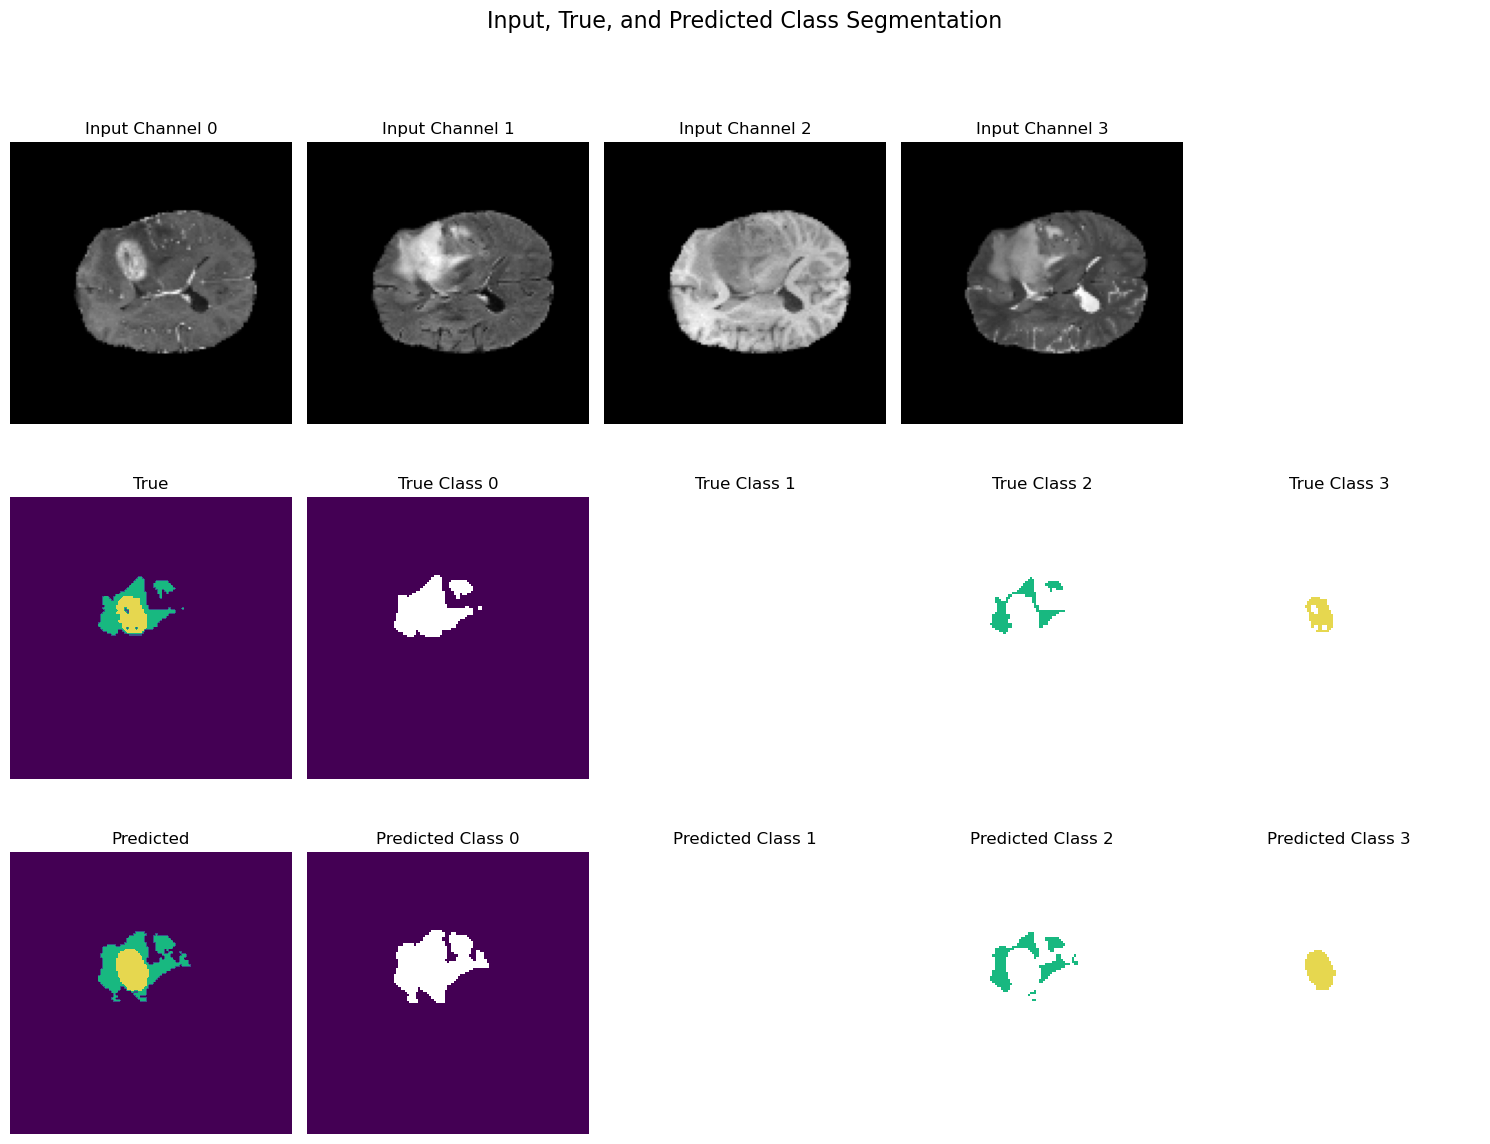

In [53]:
# Assuming `val_dataset` is your validation dataset and `model` is your trained model
model.eval()  # Set the model to evaluation mode

# Get a random sample from the validation dataset
index = random.randint(0, len(test_dataset) - 1)
input_x, true_y = test_dataset[index]

# Add a batch dimension and move to the appropriate device
input_x = input_x.unsqueeze(0).to(device)  # Shape: (1, num_channels, IMG_SIZE, IMG_SIZE)

# Get model predictions
with torch.no_grad():
    pred_y = model(input_x)

pred_y_argmax = pred_y.argmax(dim=1)

# Convert inputs and outputs to numpy for plotting
input_numpy = input_x.squeeze().cpu().numpy().astype(np.float32)  # Remove batch dimension
true_numpy = true_y.argmax(dim=0).cpu().numpy().astype(np.float32)
pred_numpy = pred_y_argmax.squeeze().cpu().numpy().astype(np.float32)


cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

class_names = ['class 0', 'class 1', 'class 2', 'class 3']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]


# Set up the number of columns as the maximum of num_channels or num_classes + 1
num_cols = max(num_channels, num_classes + 1)

# Set up figure and axes for concatenated plot
fig, axes = plt.subplots(3, num_cols, figsize=(15, 12))

# Plot input channels (first row)
for i in range(num_cols):
    if i < num_channels:
        axes[0, i].imshow(input_numpy[i], cmap='gray')
        axes[0, i].set_title(f'Input Channel {i}')
    else:
        # Hide empty subplot
        axes[0, i].axis('off')
    axes[0, i].axis('off')

# Plot true output classes (second row)
axes[1, 0].imshow(true_numpy, cmap=cmap, norm=norm)
axes[1, 0].set_title('True')
axes[1, 0].axis('off')

for i in range(1, num_cols):
    if i - 1 < num_classes:
        true_seg_numpy = true_numpy.copy()
        true_seg_numpy[true_seg_numpy != (i - 1)] = np.nan
        axes[1, i].imshow(true_seg_numpy, cmap=cmap, norm=norm)
        axes[1, i].set_title(f'True Class {i - 1}')
    else:
        # Hide empty subplot
        axes[1, i].axis('off')
    axes[1, i].axis('off')

# Plot predicted output classes (third row)
axes[2, 0].imshow(pred_numpy, cmap=cmap, norm=norm)
axes[2, 0].set_title('Predicted')
axes[2, 0].axis('off')

for i in range(1, num_cols):
    if i - 1 < num_classes:
        pred_seg_numpy = pred_numpy.copy()
        pred_seg_numpy[pred_seg_numpy != (i - 1)] = np.nan
        axes[2, i].imshow(pred_seg_numpy, cmap=cmap, norm=norm)
        axes[2, i].set_title(f'Predicted Class {i - 1}')
    else:
        # Hide empty subplot
        axes[2, i].axis('off')
    axes[2, i].axis('off')

# Add an overall title
fig.suptitle("Input, True, and Predicted Class Segmentation", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show concatenated plot in the notebook
plt.show()

# Log to wandb
wandb.log({"Segmentation Comparison": wandb.Image(fig)})

# Close the plot to free memory
plt.close(fig)  

# 17. Quantitative Evaluation: Multi-class Confusion Matrix

To understand the specific misclassification patterns of our U-Net, we compute a voxel-wise **Confusion Matrix**. This allows us to move beyond a single metric (like Dice) and see exactly which tissue types are being confused.

### Key Insights from Confusion Matrices:
* **The "Full" Matrix:** Typically dominated by Class 0 (Background). This confirms whether the model correctly distinguishes between brain tissue and non-brain areas.
* **The "Non-Background" Matrix:** By excluding Class 0, we focus on the **intra-tumor classification**. This reveals if the model struggles to differentiate between, for example, the *Necrotic Core* and the *Enhancing Tumor*.
* **Diagonal Dominance:** In a perfect model, all high numbers would be on the diagonal (top-left to bottom-right). Off-diagonal numbers represent specific error types (False Positives and False Negatives).

### Implementation Details:
* **Flattening Strategy:** Since segmentation is a pixel-wise task, we flatten the spatial dimensions ($H \times W$) of every slice in the test set to treat each pixel as an individual classification sample.
* **Seaborn Heatmaps:** We use heatmaps for better readability, allowing for immediate visual identification of classification bottlenecks.
* **W&B Integration:** Both matrices are logged to the dashboard to facilitate a comprehensive final report on the model's reliability.

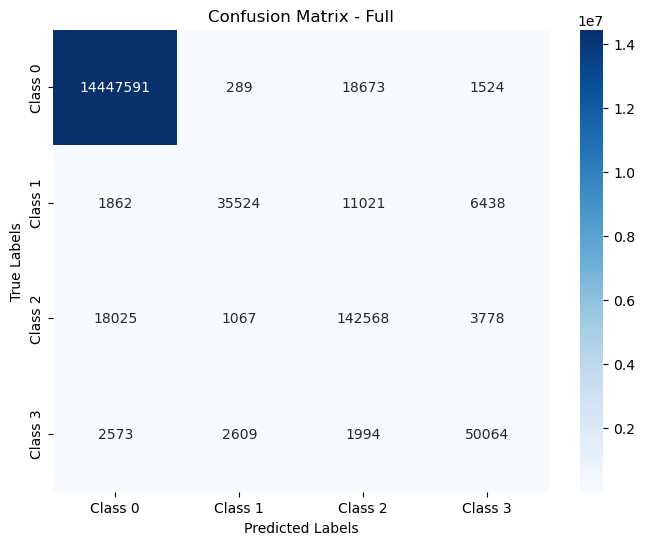

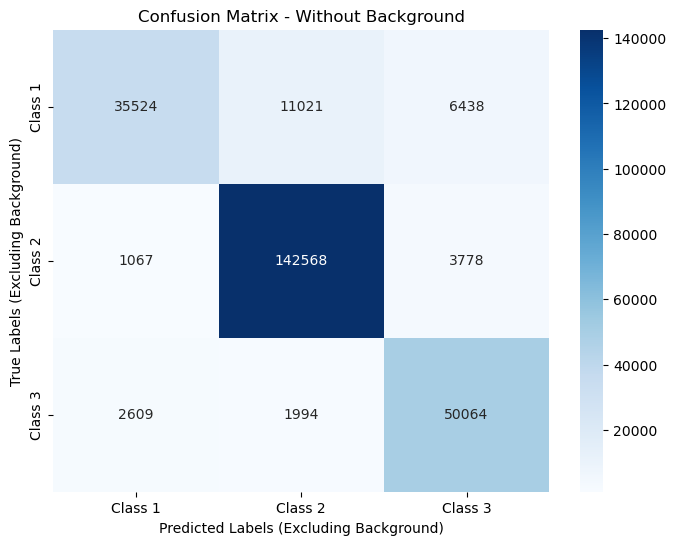

In [54]:
def conf_matrix(data_loader):
    all_true_labels = np.array([], dtype=np.int32)
    all_predicted_labels = np.array([], dtype=np.int32)

    # Loop through batches in the validation DataLoader
    for inputs, true_masks in data_loader:
        inputs = inputs.to(device)  # Shape: (batch_size, num_channels, IMG_SIZE, IMG_SIZE)
        true_masks = true_masks.to(device)  # Shape: (batch_size, num_classes, IMG_SIZE, IMG_SIZE)

        # Get model predictions
        with torch.no_grad():
            pred_masks = model(inputs)

        # Convert predictions and true masks to numpy arrays
        pred_masks_np = torch.argmax(pred_masks, dim=1).cpu().numpy()  # Shape: (batch_size, IMG_SIZE, IMG_SIZE)
        true_masks_np = true_masks.cpu().numpy()  # Shape: (batch_size, num_classes, IMG_SIZE, IMG_SIZE)

        # If true_masks is one-hot encoded, convert it to class indices
        if true_masks_np.shape[1] > 1:  # More than one channel
            true_masks_np = np.argmax(true_masks_np, axis=1)  # Shape: (batch_size, IMG_SIZE, IMG_SIZE)

        # Flatten the arrays and append to the overall arrays
        all_true_labels = np.concatenate((all_true_labels, true_masks_np.flatten()))
        all_predicted_labels = np.concatenate((all_predicted_labels, pred_masks_np.flatten()))

    # Return true and predicted labels
    return all_true_labels, all_predicted_labels

# Get true and predicted labels
all_true_labels, all_predicted_labels = conf_matrix(test_loader)

# Assuming `all_true_labels` and `all_predicted_labels` are available as PyTorch tensors
# Convert them to tensors if they are numpy arrays
all_true_labels = torch.tensor(all_true_labels)
all_predicted_labels = torch.tensor(all_predicted_labels)

# Define the confusion matrix metric
confmat = ConfusionMatrix(task="multiclass", num_classes=num_classes)

# Compute the confusion matrix
cm = confmat(all_predicted_labels, all_true_labels)

# Plot and log the full confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm.numpy(), annot=True, fmt="d", cmap="Blues", 
            xticklabels=[f'Class {i}' for i in range(num_classes)], 
            yticklabels=[f'Class {i}' for i in range(num_classes)])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Full")

# Log to wandb
wandb.log({"Confusion Matrix - Full": wandb.Image(plt)})
plt.show()

# Remove the background class (assumed to be class 0)
cm_no_bg = cm[1:, 1:]  # Exclude the first row and column

# Plot and log the confusion matrix without the background class
plt.figure(figsize=(8, 6))
sns.heatmap(cm_no_bg.numpy(), annot=True, fmt="d", cmap="Blues", 
            xticklabels=[f'Class {i}' for i in range(1, num_classes)], 
            yticklabels=[f'Class {i}' for i in range(1, num_classes)])
plt.xlabel("Predicted Labels (Excluding Background)")
plt.ylabel("True Labels (Excluding Background)")
plt.title("Confusion Matrix - Without Background")

# Log to wandb
wandb.log({"Confusion Matrix - Without Background": wandb.Image(plt)})
plt.show()

# 18. Final Statistical Analysis: Class-wise Performance Metrics

To conclude the study, we extract detailed statistical metrics from the confusion matrix. In medical imaging, understanding the trade-off between **Sensitivity** and **Specificity** is vital for clinical validation.

### Metrics Calculated per Class:
* **Sensitivity (TPR):** Ability of the model to correctly detect the tumor regions.
* **Specificity (TNR):** Ability to correctly identify healthy tissue.
* **PPV (Precision):** Reliability of the model's positive predictions.
* **Dice Score:** The definitive spatial overlap metric for the BraTS 2020 challenge.

### Reporting and Persistence:
* **Interactive Table:** A `wandb.Table` is generated containing all TP, TN, FP, and FN values alongside their derived rates. This provides a granular view of where the model excels or struggles.
* **Final Summary:** The average Dice score across all classes is logged as the primary performance indicator for this specific model architecture.
* **Experiment Finalization:** `run.finish()` ensures all artifacts (model weights) and logs are safely stored in the cloud for future reference and reproducibility.

In [55]:
def perf_measure(conf_matrix, numberOfClasses):
    CM = conf_matrix

    # Create a list to store the rows for the table
    table_data = []
    avg_dice_score = 0

    for i in range(numberOfClasses):
        
        TP = float(CM[i][i])
        FP = float(CM[i,:].sum() - TP)
        FN = float(CM[:,i].sum() - TP)
        TN = float(CM[:,:].sum() - TP - FP - FN)

        # Debug: Print TP, FP, FN, TN for each class to diagnose
        print(f"Class {i+1}: TP={TP}, TN={TN}, FP={FP}, FN={FN}")

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP / (TP + FN) if (TP + FN) != 0 else float('nan')

        # Specificity or true negative rate
        TNR = TN / (TN + FP) if (TN + FP) != 0 else float('nan')

        # PPV positive predictive value
        PPV = TP / (TP + FP) if (TP + FP) != 0 else float('nan')

        # NPV negative predictive value
        NPV = TN / (TN + FN) if (TN + FN) != 0 else float('nan')

        # Accuracy
        ACC = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) != 0 else float('nan')

        # Dice score
        DS = (2 * TP) / ((2 * TP) + FP + FN) if ((2 * TP) + FP + FN) != 0 else float('nan')
        avg_dice_score += DS

        print("True positive rate :", TPR)
        print("True negative rate :", TNR)
        print("Positive predictive value :", PPV)
        print("Negative predictive value :", NPV)
        print("Accuracy :", ACC)
        print("Dice score :", DS, '\n')

        # Create a row for this class's metrics
        row = [i + 1, TP, TN, FP, FN, TPR, TNR, PPV, NPV, ACC, DS]

        # Append the row to the table data list
        table_data.append(row)
    
    # Create a wandb.Table from the table data
    table = wandb.Table(columns=[
        "Class", 
        "True Positive", 
        "True Negative", 
        "False Positive", 
        "False Negative", 
        "True Positive Rate", 
        "True Negative Rate", 
        "Positive Predictive Value", 
        "Negative Predictive Value", 
        "Accuracy", 
        "Dice Score"
    ], data=table_data)

    # Log the table to wandb
    wandb.log({"Performance Metrics Table": table})

    avg_dice_score /= numberOfClasses
    wandb.run.summary["test dice score"] = avg_dice_score


# Output classes
print(f"Number of classes: {num_classes}")

perf_measure(cm.numpy(), num_classes)

Number of classes: 4
Class 1: TP=14447591.0, TN=255063.0, FP=20486.0, FN=22460.0
True positive rate : 0.9984478285529194
True negative rate : 0.9256538764430283
Positive predictive value : 0.9985840550890074
Negative predictive value : 0.9190697707937721
Accuracy : 0.9970875379774305
Dice score : 0.9985159371746507 

Class 2: TP=35524.0, TN=14686790.0, FP=19321.0, FN=3965.0
True positive rate : 0.8995922915242219
True negative rate : 0.9986861924270801
Positive predictive value : 0.6477162913665785
Negative predictive value : 0.9997301023671009
Accuracy : 0.9984208170572917
Dice score : 0.7531536879598024 

Class 3: TP=142568.0, TN=14548474.0, FP=22870.0, FN=31688.0
True positive rate : 0.8181526030667524
True negative rate : 0.9984304810867137
Positive predictive value : 0.8617609013648617
Negative predictive value : 0.9978266359454716
Accuracy : 0.996300048828125
Dice score : 0.8393907457888571 

Class 4: TP=50064.0, TN=14676620.0, FP=7176.0, FN=11740.0
True positive rate : 0.8100446

In [56]:
run.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


ce_loss,▇▇█▃▅▃▄▆▄▄▃▂▄▄▃▄▂▂▂▂▂▂▃▂▄▃▃▁▂▁▁▃▃▂▁▂▂▂▁▂
dice_loss,█▅▃▃▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▁▁▂▂▁▁▂▂▂▂▁▁▁▁▁▂▁▂▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇████
learning rate,████████████████████████████▄▄▄▄▄▄▄▂▂▂▁▁
loss,█▅▄▂▃▃▄▃▂▃▂▃▂▃▂▁▂▃▂▂▂▂▂▁▂▂▂▁▂▂▂▃▁▁▂▁▂▂▁▁
val_dice_score,▁▂▂▅▆▆▇█▇▁▇█▇▇▆▇█▇▇█▇▇
val_loss,█▄▄▃▂▃▃▂▂▇▂▁▂▁▂▁▁▂▁▁▂▁
Model Parameters,4683005
ce_loss,0.00637
dice_loss,0.0039
epoch,22
